In [1]:
# Instalar librerías si es necesario
# Desinstala cualquier versión incorrecta
#!pip uninstall -y prince

# Instala la versión correcta desde GitHub
#!pip install git+https://github.com/MaxHalford/prince.git



In [2]:

# Importar librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
#import prince
from scipy.stats import skew, variation, kstest, shapiro, norm
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

In [3]:
# Leer los datos
airq_dt = pd.read_csv("airq_dt.csv")

In [4]:
# Dimensiones y vista previa
print(airq_dt.shape)
print()
print(airq_dt.head())
print()
print(airq_dt.info())

(100, 6)

   Ozono  RadSol  Vient  Temp  Mes  Dia
0   21.0   259.0   15.5    76    9   12
1   32.0    92.0   12.0    61    5   24
2   20.0    37.0    9.2    65    6   18
3    NaN   139.0    8.6    82    7   11
4   28.0   273.0   11.5    82    8   13

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ozono   82 non-null     float64
 1   RadSol  96 non-null     float64
 2   Vient   100 non-null    float64
 3   Temp    100 non-null    int64  
 4   Mes     100 non-null    int64  
 5   Dia     100 non-null    int64  
dtypes: float64(3), int64(3)
memory usage: 4.8 KB
None


In [5]:
# Visualizar datos faltantes
print(airq_dt.isnull().sum())


Ozono     18
RadSol     4
Vient      0
Temp       0
Mes        0
Dia        0
dtype: int64


In [6]:
# Diagnóstico de variables categóricas
airq_dt['Mes.ch'] = airq_dt['Mes'].astype(str)
print(airq_dt['Mes.ch'].value_counts())

Mes.ch
8    24
5    22
9    21
7    17
6    16
Name: count, dtype: int64


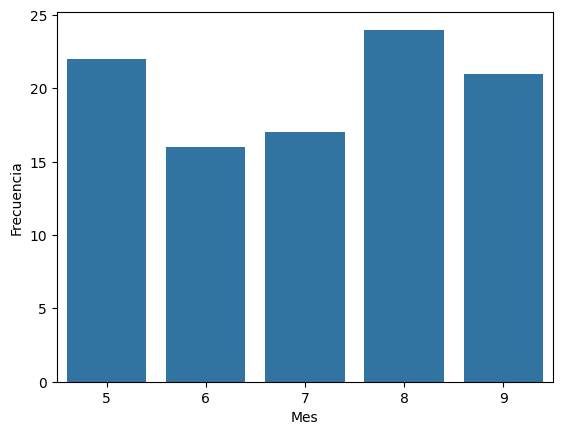

In [7]:
# Gráfico de barras
sns.countplot(x='Mes', data=airq_dt)
plt.xlabel("Mes")
plt.ylabel("Frecuencia")
plt.show()

In [8]:
# Análisis de variables numéricas
print(airq_dt['Ozono'].describe())
print("Coeficiente de asimetría:", skew(airq_dt['Ozono'].dropna()))
print("Coeficiente de variación:", variation(airq_dt['Ozono'].dropna()))

count     82.000000
mean      41.073171
std       35.022314
min        1.000000
25%       16.000000
50%       29.000000
75%       51.500000
max      168.000000
Name: Ozono, dtype: float64
Coeficiente de asimetría: 1.3931633543556752
Coeficiente de variación: 0.8474658192068988


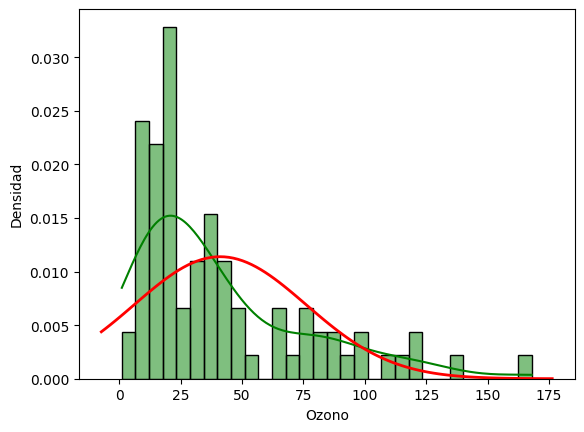

In [9]:
# Histograma con curva de densidad
# Este gráfico muestra la distribución de los valores de ozono, combinando:
# - un histograma normalizado a densidad
# - una curva de densidad empírica (kde)
# - y una curva de densidad teórica normal para comparación visual

# Histograma y densidad empírica (KDE)
sns.histplot(airq_dt['Ozono'].dropna(), kde=True, stat="density", color="green", bins=30)

# Media y desviación estándar de Ozono (usadas para la curva normal teórica)
mean_oz = airq_dt['Ozono'].mean()
std_oz = airq_dt['Ozono'].std()

# Crear rango de valores en el eje X para evaluar la densidad normal
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# Calcular la densidad de la distribución normal con media y desviación estándar calculadas
p = norm.pdf(x, mean_oz, std_oz)

# Agregar la curva normal en rojo
plt.plot(x, p, 'r', linewidth=2)

# Etiquetas y visualización
plt.xlabel("Ozono")
plt.ylabel("Densidad")
plt.show()


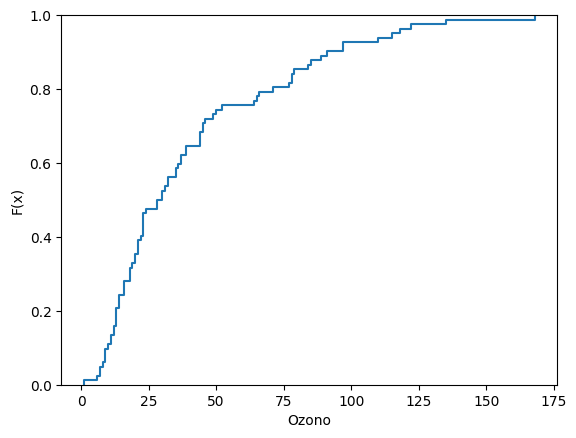

In [10]:
# Distribución empírica acumulada (ECDF)
# Este gráfico muestra la función de distribución acumulada empírica de los valores de ozono.
# Permite visualizar cómo se distribuyen los datos y estimar percentiles visualmente.

# Graficar la ECDF de la variable 'Ozono'
sns.ecdfplot(data=airq_dt, x='Ozono')

# Etiquetas de los ejes
plt.xlabel("Ozono")      # Valores de ozono en el eje X
plt.ylabel("F(x)")       # Probabilidad acumulada en el eje Y

# Mostrar el gráfico
plt.show()


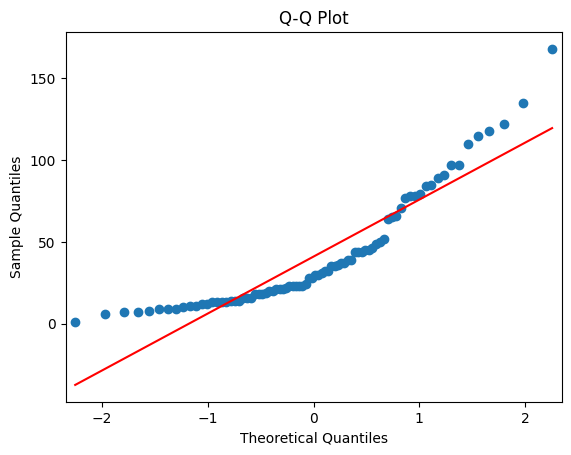

In [11]:
# Q-Q plot (Quantile-Quantile plot)
# Este gráfico compara los cuantiles de la variable 'Ozono' con los cuantiles de una distribución normal.
# Si los datos siguen una distribución normal, los puntos deberían alinearse cerca de la línea diagonal.

# Importar statsmodels para usar la función qqplot
import statsmodels.api as sm

# Crear el gráfico Q-Q usando los datos de Ozono sin valores nulos
# line='s' dibuja una línea de referencia con la misma pendiente y centro que los datos teóricos
sm.qqplot(airq_dt['Ozono'].dropna(), line='s')

# Título del gráfico
plt.title("Q-Q Plot")

# Mostrar el gráfico
plt.show()


In [12]:
# Pruebas de normalidad
# Estas pruebas estadísticas permiten evaluar si los datos siguen una distribución normal.
# Se utilizan para validar supuestos antes de aplicar ciertos métodos estadísticos.

# 1. Kolmogorov-Smirnov (KS) test
# Compara la distribución acumulada empírica de los datos con una distribución teórica (en este caso, normal).
# Ho: los datos siguen una distribución normal con media y desviación estándar dadas
# H1: los datos no siguen esa distribución normal

from scipy.stats import kstest, shapiro

# Parámetros de la distribución normal teórica
mean_oz = airq_dt['Ozono'].mean()
std_oz = airq_dt['Ozono'].std()

# Aplicar KS test a los datos de Ozono
print("KS Test:", kstest(airq_dt['Ozono'].dropna(), 'norm', args=(mean_oz, std_oz)))

# 2. Shapiro-Wilk test para Ozono
# Esta prueba también evalúa la normalidad, pero es más precisa para muestras pequeñas y medianas (< 5000 obs).
# Ho: los datos provienen de una distribución normal
# H1: los datos no provienen de una distribución normal
print("Shapiro Ozono:", shapiro(airq_dt['Ozono'].dropna()))

# 3. Shapiro-Wilk test para la variable Vient
print("Shapiro Vient:", shapiro(airq_dt['Vient'].dropna()))

#Cada una de las pruebas devuelve un estadístico y un valor-p (p-value):

#Si el valor-p > 0.05, no se rechaza la hipótesis nula → los datos podrían ser normales.

#Si el valor-p < 0.05, se rechaza la hipótesis nula → los datos no siguen una distribución normal.

KS Test: KstestResult(statistic=np.float64(0.1699433499657083), pvalue=np.float64(0.01537072655916777), statistic_location=np.float64(39.0), statistic_sign=np.int8(1))
Shapiro Ozono: ShapiroResult(statistic=np.float64(0.8427469223803885), pvalue=np.float64(7.036738454987334e-08))
Shapiro Vient: ShapiroResult(statistic=np.float64(0.9833954264900511), pvalue=np.float64(0.2419978523575051))


In [13]:
# Detección de valores atípicos usando el criterio del rango intercuartil (IQR)
# Este método es útil para identificar datos extremos sin asumir una distribución específica.

# 1. Calcular el primer cuartil (Q1) → 25% de los datos están por debajo de este valor
Q1 = airq_dt['Ozono'].quantile(0.25)

# 2. Calcular el tercer cuartil (Q3) → 75% de los datos están por debajo de este valor
Q3 = airq_dt['Ozono'].quantile(0.75)

# 3. Calcular el rango intercuartil (IQR) → Q3 - Q1
IQR = Q3 - Q1

# 4. Definir los límites para detectar outliers:
# - Límite inferior (LI): Q1 - 1.5 * IQR
# - Límite superior (LS): Q3 + 1.5 * IQR
LI = Q1 - 1.5 * IQR
LS = Q3 + 1.5 * IQR

# 5. Identificar los valores atípicos:
# - Valores por encima del límite superior
outliers_sup = airq_dt['Ozono'] >= LS

# - Valores por debajo del límite inferior
outliers_inf = airq_dt['Ozono'] <= LI

# 6. Imprimir los valores detectados como atípicos
print("Valores atípicos superiores:", airq_dt['Ozono'][outliers_sup])
print("Valores atípicos inferiores:", airq_dt['Ozono'][outliers_inf])


Valores atípicos superiores: 15    118.0
20    110.0
51    135.0
56    115.0
66    122.0
91    168.0
Name: Ozono, dtype: float64
Valores atípicos inferiores: Series([], Name: Ozono, dtype: float64)


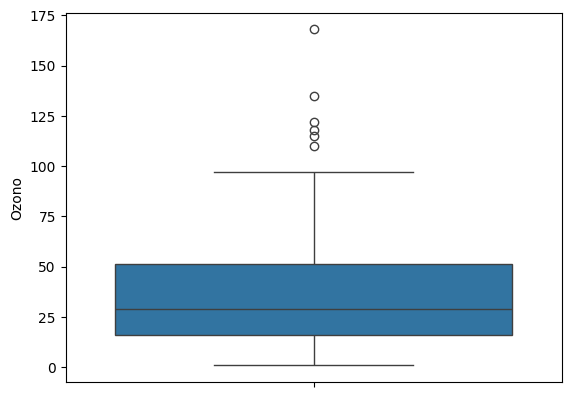

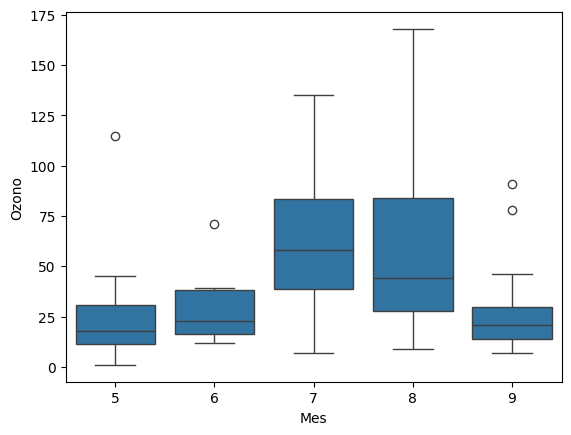

In [14]:
# Boxplot general y por mes
sns.boxplot(y='Ozono', data=airq_dt)
plt.show()
sns.boxplot(x='Mes', y='Ozono', data=airq_dt)
plt.show()

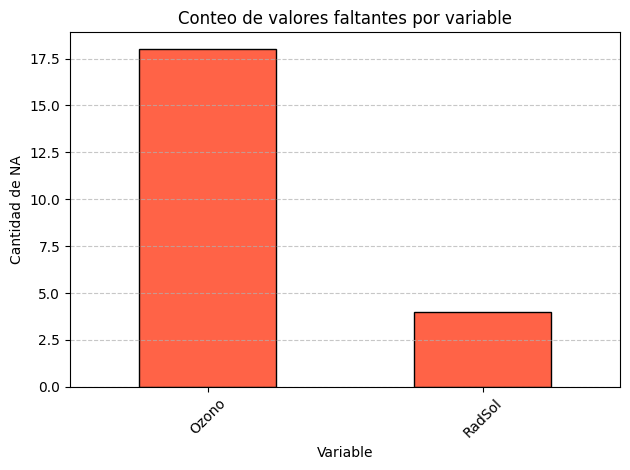

In [15]:
# Gráfico de barras simple para visualizar valores faltantes por variable

# Calcular cantidad de valores nulos por columna
missing_counts = airq_dt.isnull().sum()

# Filtrar solo las columnas con al menos un valor perdido
missing_counts = missing_counts[missing_counts > 0]

# Graficar
missing_counts.plot(kind='bar', color='tomato', edgecolor='black')
plt.title("Conteo de valores faltantes por variable")
plt.ylabel("Cantidad de NA")
plt.xlabel("Variable")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [16]:
# Imputación de datos faltantes por la media (forma recomendada)
# Se crea una nueva columna 'Oz.imp' con los mismos valores de 'Ozono',
# pero reemplazando los NA por la media

airq_dt['Oz.imp'] = airq_dt['Ozono'].fillna(airq_dt['Ozono'].mean())

# Verificar un valor imputado (por ejemplo, fila 4)
print(airq_dt.loc[4, 'Oz.imp'])


28.0


In [17]:
# Imputación múltiple (versión simple usando SimpleImputer con media)
# Este ejemplo aplica imputación por la media a varias columnas del DataFrame.
# Es útil cuando quieres imputar varios campos numéricos de forma consistente.

from sklearn.impute import SimpleImputer

# Seleccionar las primeras 6 columnas del DataFrame (como en el script original de R)
# Puedes ajustar esto según las columnas que realmente quieras imputar
imp_cols = airq_dt.columns[:6]

# Crear un imputador que reemplazará los valores faltantes con la media de cada columna
imp = SimpleImputer(strategy='mean')

# Aplicar la imputación y reconstruir un DataFrame con los mismos nombres de columna
airq_imp_df = pd.DataFrame(imp.fit_transform(airq_dt[imp_cols]), columns=imp_cols)

# Mostrar las primeras filas del nuevo DataFrame imputado
print(airq_imp_df.head())


       Ozono  RadSol  Vient  Temp  Mes   Dia
0  21.000000   259.0   15.5  76.0  9.0  12.0
1  32.000000    92.0   12.0  61.0  5.0  24.0
2  20.000000    37.0    9.2  65.0  6.0  18.0
3  41.073171   139.0    8.6  82.0  7.0  11.0
4  28.000000   273.0   11.5  82.0  8.0  13.0


Análisis PCA

In [18]:
# ==============================================================================
# ANÁLISIS DE COMPONENTES PRINCIPALES (PCA) CON sklearn
# ==============================================================================

# Importamos:
# - StandardScaler: para escalar (estandarizar) las variables antes del PCA.
# - PCA: para realizar el análisis de componentes principales.
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ==============================================================================
# 1. ESTANDARIZACIÓN DE LOS DATOS
# ==============================================================================

# Creamos un objeto StandardScaler para transformar los datos:
# Esta transformación hace que cada variable tenga:
# - media = 0
# - desviación estándar = 1
# Esto es necesario en PCA cuando las variables están en diferentes escalas,
# ya que sin esto, las variables con mayor varianza dominarían el análisis.
scaler = StandardScaler()

# Aplicamos el escalamiento sobre los datos imputados (sin NA)
X_scaled = scaler.fit_transform(airq_imp_df)

# ==============================================================================
# 2. APLICAR PCA
# ==============================================================================

# Creamos el modelo PCA (no especificamos n_components para obtener todos)
pca = PCA()

# Ajustamos el modelo a los datos estandarizados
pca.fit(X_scaled)

# ==============================================================================
# 3. CÁLCULO DE COORDENADAS DE LAS VARIABLES (loadings)
# ==============================================================================

# Las "componentes_" en PCA contienen los vectores propios (ejes) del nuevo espacio.
# Transponemos esa matriz para obtener los "loadings":
# - Cada fila corresponde a una variable original
# - Cada columna corresponde a un componente principal
loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
                        index=airq_imp_df.columns)

# Mostramos las coordenadas en PC1 y PC2
print("Coordenadas (loadings):")
print(loadings.iloc[:, :2])  # Coordenadas de cada variable en PC1 y PC2

# ==============================================================================
# 4. CONTRIBUCIÓN DE LAS VARIABLES A LOS COMPONENTES
# ==============================================================================

# Calculamos la contribución relativa de cada variable a cada componente
# Fórmula:
# contrib_ij = (loading_ij)^2 / suma_total(loadings_j^2) * 100
# Esto nos dice qué porcentaje del componente PCj está "explicado" por la variable i
loadings_sq = loadings ** 2  # Elevamos al cuadrado los loadings
contrib = loadings_sq.div(loadings_sq.sum(axis=0), axis=1) * 100

# Mostramos las contribuciones para PC1 y PC2
print("\nContribuciones (%):")
print(contrib.iloc[:, :2])

# ==============================================================================
# 5. COS² (Calidad de representación)
# ==============================================================================

# El cos² mide qué tan bien está representada cada variable en el plano factorial (PC1 y PC2)
# Se calcula simplemente como el cuadrado del loading
# Cuanto mayor el cos², mejor la proyección de esa variable en ese componente
print("\nCos2:")
print(loadings_sq.iloc[:, :2])


Coordenadas (loadings):
             PC1       PC2
Ozono   0.525684  0.131172
RadSol  0.269946  0.670468
Vient  -0.478986  0.199286
Temp    0.552409 -0.077396
Mes     0.285642 -0.611143
Dia    -0.186040 -0.337736

Contribuciones (%):
              PC1        PC2
Ozono   27.634316   1.720614
RadSol   7.287067  44.952724
Vient   22.942794   3.971509
Temp    30.515576   0.599008
Mes      8.159139  37.349550
Dia      3.461106  11.406594

Cos2:
             PC1       PC2
Ozono   0.276343  0.017206
RadSol  0.072871  0.449527
Vient   0.229428  0.039715
Temp    0.305156  0.005990
Mes     0.081591  0.373495
Dia     0.034611  0.114066


In [19]:
# Media y desviación estándar usadas en estandarización
print("Media (center):", scaler.mean_)
print("Desviaciones estándar (scale):", np.sqrt(scaler.var_))
#
#¿Para qué sirve mostrar esto?
## Para documentar cómo fueron transformadas las variables.
## Para interpretar posteriormente los loadings del PCA en términos originales.
## Y para revertir la transformación si fuese necesario (inversa del StandardScaler).



Media (center): [ 41.07317073 185.47916667  10.206       77.52         7.06
  15.39      ]
Desviaciones estándar (scale): [31.52008264 92.57699273  3.72117777  9.56815552  1.45478521  8.34373418]


In [20]:
# MATRIZ DE ROTACIÓN (también conocida como "loadings" o "vectores propios")
# ----------------------------------------------------------
# Esta matriz contiene las **coordenadas de las variables originales**
# proyectadas en los nuevos ejes creados por el PCA (los componentes principales).
#
# Cada columna representa un componente principal (PC1, PC2, ...).
# Cada fila representa una variable original.
#
# Estos valores indican:
# - cuánto contribuye cada variable a la dirección de ese componente.
# - la correlación entre la variable original y el componente.
#
# En otras palabras:
# - Si el valor es alto → la variable está muy alineada con ese componente.
# - Si es cercano a 0 → la variable no influye mucho en ese eje.
#
# Este objeto suele llamarse "matriz de rotación" en R, y en sklearn se obtiene como:
#     pca.components_.T  → transponemos para que queden como en R: variables en filas
print("Componentes principales (rotation):")
print(pca.components_.T)



Componentes principales (rotation):
[[ 0.52568352  0.13117219  0.31514125 -0.20348768  0.36740866  0.6563081 ]
 [ 0.26994569  0.67046793  0.05254509  0.57867511 -0.37389824  0.01327858]
 [-0.47898637  0.19928646 -0.25311501  0.43171328  0.65243293  0.23397579]
 [ 0.55240905 -0.07739564 -0.0620599   0.18134253  0.5097373  -0.62632699]
 [ 0.28564207 -0.61114278 -0.40137161  0.47573675 -0.19755821  0.34417908]
 [-0.18604048 -0.3377365   0.81786747  0.42206748  0.02609402 -0.05994953]]


In [21]:
# PUNTAJES DE LOS INDIVIDUOS (también llamados "scores" o "coordenadas de las observaciones")
# ------------------------------------------------------------------------------------------

# Obtener los puntajes (observaciones proyectadas en el nuevo espacio)
X_pca = pca.transform(X_scaled)


# Aquí se muestran las primeras filas de la matriz de datos proyectada en el nuevo sistema
# de ejes creado por el PCA (los componentes principales).
#
# Cada fila representa una observación (individuo, muestra, fila del dataset original).
# Cada columna representa un componente principal (PC1, PC2, ...).
#
# Estos valores son el resultado de aplicar la transformación PCA:
#     X_pca = X_estandarizado × vectores propios (componentes)
#
# Se interpretan como las "coordenadas" de cada individuo en el nuevo espacio reducido,
# y son útiles para:
# - visualizar la dispersión de los datos en 2D o 3D (scatterplot)
# - detectar patrones, agrupamientos, outliers
# - alimentar modelos de machine learning con menos dimensiones


print("Primeras filas de los puntajes (X_pca):")
print(pd.DataFrame(X_pca).head())


Primeras filas de los puntajes (X_pca):
          0         1         2         3         4         5
0 -0.433090  0.066979 -1.376739  1.637451  0.042252  0.508282
1 -2.205037  0.031819  1.253667 -0.868822  0.012904  0.442638
2 -1.644066 -0.775977  0.402956 -1.360669 -0.337228  0.026687
3  0.415946 -0.255959 -0.359960 -0.633631  0.139228 -0.383559
4  0.367114  0.314363 -0.691723  1.052996 -0.175442 -0.231990


In [22]:
# PROPORCIÓN DE VARIANZA EXPLICADA (PVE)
# ---------------------------------------
# Después de aplicar PCA, es importante saber cuánto aporta cada componente principal
# a la explicación de la variabilidad total de los datos originales.
#
# 1. pca.explained_variance_:
#    → contiene la **varianza** que explica cada componente principal (autovalores).
#
# 2. pca.explained_variance_ratio_:
#    → contiene la **proporción** de la varianza total explicada por cada componente,
#       es decir, el porcentaje de información del dataset original que retiene cada PC.
#
#    Por ejemplo, si PC1 tiene un PVE = 0.45, significa que PC1 explica el 45% de la variabilidad total.
#
# Esto es clave para decidir:
# - cuántos componentes conservar
# - cuánta información se pierde si se reducen dimensiones
# - si el PCA es útil para visualizar, resumir o clasificar

VE = pca.explained_variance_             # Varianzas de los componentes
PVE = pca.explained_variance_ratio_      # Proporción explicada por cada PC

print("Proporción de varianza explicada por cada componente:")
print(np.round(PVE, 2))  # Redondeado a dos decimales para facilitar lectura


Proporción de varianza explicada por cada componente:
[0.4  0.19 0.16 0.12 0.07 0.05]


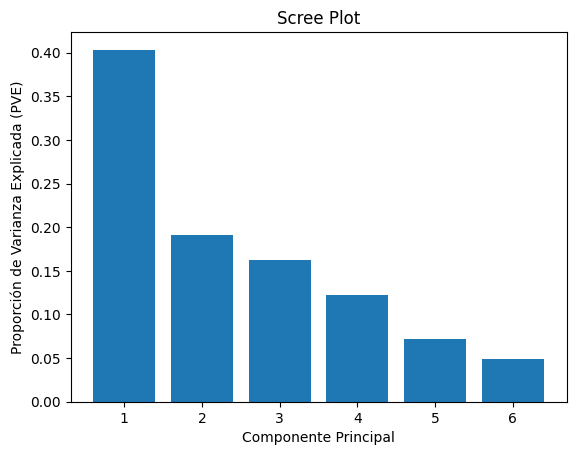

In [23]:
# SCREE PLOT (Gráfico de sedimentación o de codo)
# -------------------------------------------------
# Este gráfico permite visualizar cuánta varianza explica cada componente principal.
# En el eje X se representan los componentes principales (PC1, PC2, ...).
# En el eje Y, la proporción de varianza explicada por cada uno (PVE).
#
# ¿Para qué sirve?
# - Para decidir cuántos componentes retener sin perder demasiada información.
# - Se busca el "punto de codo", es decir, el lugar donde la ganancia de información
#   adicional se vuelve marginal. Desde ahí se justifica cortar.
#
# Esto se conoce como la "regla del codo" y es útil para reducir dimensiones de forma informada.

plt.bar(range(1, len(PVE) + 1), PVE)  # Barra por cada componente
plt.xlabel("Componente Principal")
plt.ylabel("Proporción de Varianza Explicada (PVE)")
plt.title("Scree Plot")
plt.show()

## NOTA :
## Si ves que los primeros 2 o 3 componentes explican más del 80% de la varianza, puedes reducir el dataset a solo esos componentes.
## Si la curva desciende rápidamente y luego se aplana, ese "codo" indica un buen punto de corte.

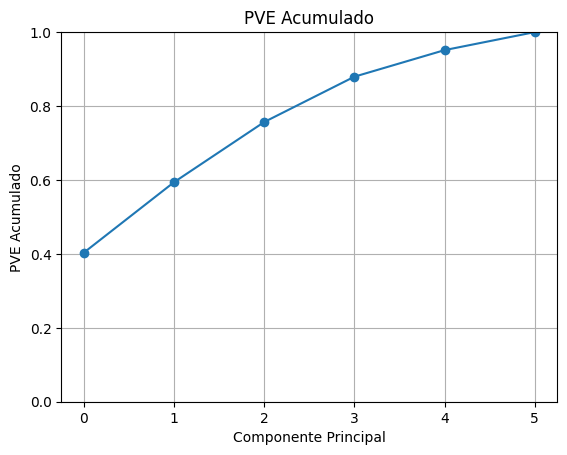

In [24]:
# GRÁFICO DE PVE ACUMULADO
# -------------------------------------------------------
# Este gráfico muestra cuánta varianza total se ha acumulado al incluir
# progresivamente más componentes principales.
#
# En el eje X: número de componentes principales (PC1, PC2, ...)
# En el eje Y: proporción acumulada de varianza explicada hasta ese componente
#
# np.cumsum(PVE): calcula la suma acumulativa de la proporción de varianza explicada.
#
# Este gráfico complementa al "Scree Plot" y ayuda a decidir
# cuántos componentes conservar para alcanzar un umbral deseado
# de varianza retenida, por ejemplo: 80% o 90%.

plt.plot(np.cumsum(PVE), marker='o')       # Línea con marcador para cada PC
plt.xlabel("Componente Principal")         # Etiqueta del eje X
plt.ylabel("PVE Acumulado")                # Etiqueta del eje Y
plt.title("PVE Acumulado")                 # Título del gráfico
plt.ylim(0, 1)                              # Limitar eje Y entre 0 y 1 (0% a 100%)
plt.grid(True)                              # Agregar líneas guía
plt.show()

## NOTA
## Este gráfico responde la pregunta:
##  “¿Cuántos componentes necesito para explicar al menos X% de la variabilidad?”
## Ejemplo: si en PC3 ya tienes 85% acumulado → puedes trabajar con solo 3 componentes sin perder mucha información.

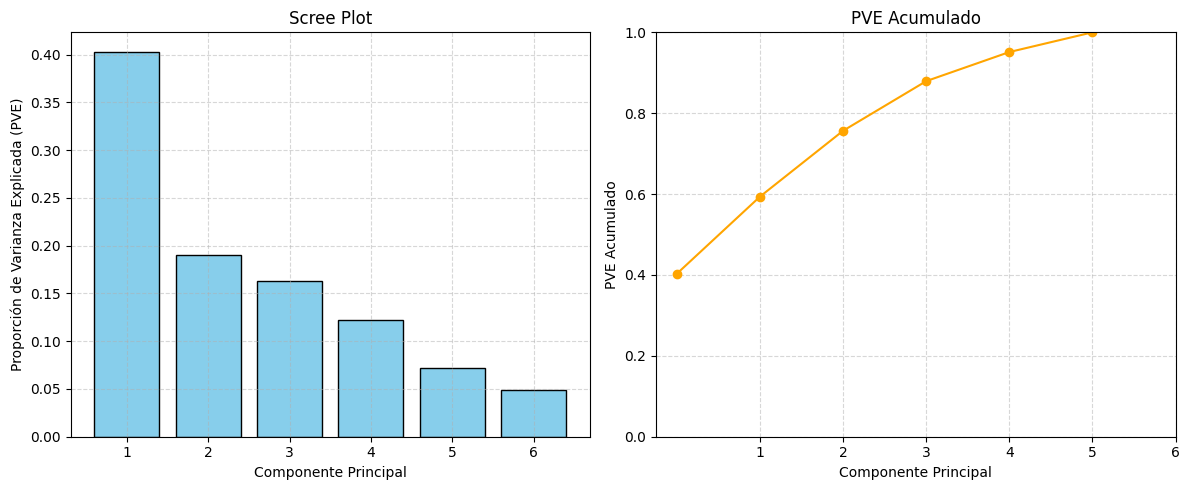

In [25]:
## Gráficos combinados

# Crear figura con dos subplots en una misma fila
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# === 1. Scree Plot ===
axes[0].bar(range(1, len(PVE) + 1), PVE, color='skyblue', edgecolor='black')
axes[0].set_xlabel("Componente Principal")
axes[0].set_ylabel("Proporción de Varianza Explicada (PVE)")
axes[0].set_title("Scree Plot")
axes[0].set_xticks(range(1, len(PVE) + 1))
axes[0].grid(True, linestyle='--', alpha=0.5)

# === 2. PVE acumulado ===
axes[1].plot(np.cumsum(PVE), marker='o', color='orange')
axes[1].set_xlabel("Componente Principal")
axes[1].set_ylabel("PVE Acumulado")
axes[1].set_title("PVE Acumulado")
axes[1].set_ylim(0, 1)
axes[1].set_xticks(range(1, len(PVE) + 1))
axes[1].grid(True, linestyle='--', alpha=0.5)

# Ajustar espaciado entre gráficos
plt.tight_layout()
plt.show()

In [26]:
# EIGENVALUES (VALORES PROPIOS)
# ------------------------------------------------------
# Los eigenvalues (valores propios) son fundamentales en el análisis de componentes principales (PCA).
#
# Cada componente principal (PC1, PC2, ...) tiene un eigenvalue asociado que representa:
# → La cantidad de varianza del conjunto de datos original que ese componente explica.
#
# Interpretación:
# - Cuanto mayor sea el eigenvalue, más importante es ese componente.
# - Un eigenvalue cercano a 0 indica que el componente explica muy poca variabilidad.
#
# Este resultado es equivalente a los autovalores que entrega la función summary() en R.
# También son la base para calcular:
# - La Proporción de Varianza Explicada (PVE)
# - La Varianza Acumulada
# - Y para decidir cuántos componentes conservar
#
# En este caso, estamos usando el método .eigenvalues_ del PCA de prince.

eig_vals = pca.explained_variance_
print("Eigenvalues:")
print(eig_vals)



## NOTA
## Según la regla de Kaiser, a veces se sugiere conservar los componentes con eigenvalues > 1 (especialmente cuando las variables fueron estandarizadas).


Eigenvalues:
[2.44429578 1.15522231 0.98655935 0.74354264 0.43574697 0.29523901]


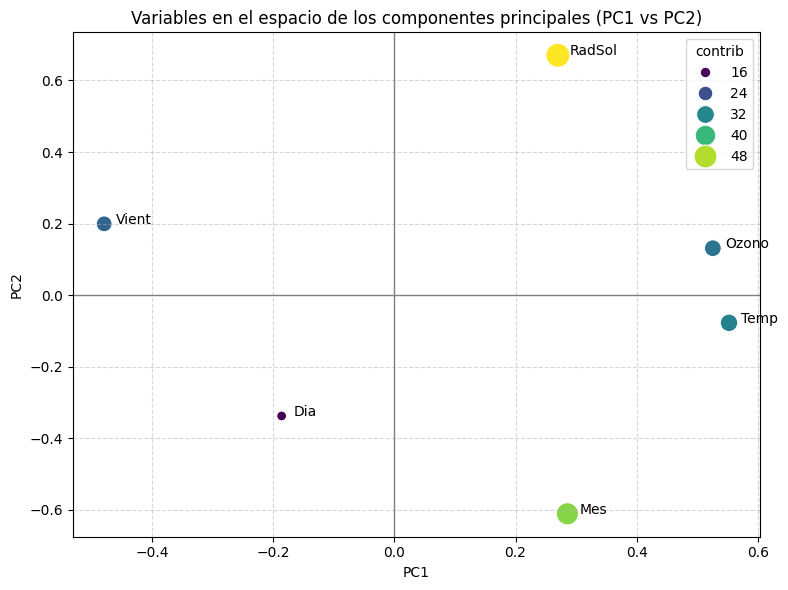

In [27]:
# VISUALIZACIÓN DE LAS VARIABLES EN EL ESPACIO PCA (tipo fviz_pca_var)
# ---------------------------------------------------------------------

# Crear un DataFrame con las coordenadas de las variables en los dos primeros componentes
pca_vars = loadings.iloc[:, :2].copy()  # Tomamos las columnas PC1 y PC2 de los loadings

# Calcular la contribución total de cada variable a los dos primeros componentes
# Esto nos indica qué variables tienen mayor peso en la construcción del plano PC1-PC2
pca_vars['contrib'] = contrib.iloc[:, :2].sum(axis=1)

# Agregamos una columna con el nombre de la variable (índice del DataFrame original)
pca_vars['var'] = pca_vars.index

# ----------------------------------------------------------
# GRÁFICO DE DISPERSIÓN: variables proyectadas en PC1 y PC2
# ----------------------------------------------------------

# Crear figura
plt.figure(figsize=(8, 6))

# Graficar las variables como puntos en el plano PC1-PC2
# El color y el tamaño de cada punto representan la contribución de la variable al plano
sns.scatterplot(data=pca_vars, x='PC1', y='PC2',
                size='contrib', sizes=(50, 300),
                hue='contrib', palette='viridis', legend='brief')

# Agregar etiquetas con los nombres de las variables (ajustadas para no superponerse)
for i in range(pca_vars.shape[0]):
    plt.text(pca_vars.iloc[i]['PC1'] + 0.02,   # desplazamiento leve en X
             pca_vars.iloc[i]['PC2'],         # posición en Y
             pca_vars.iloc[i]['var'],         # texto: nombre de la variable
             fontsize=10)

# Añadir líneas horizontales y verticales en el origen
plt.axhline(0, color='gray', lw=1)
plt.axvline(0, color='gray', lw=1)

# Títulos y etiquetas
plt.title("Variables en el espacio de los componentes principales (PC1 vs PC2)")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Estética general
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


##NOTA:
## Muestra cómo se orientan las variables originales en relación con los dos primeros componentes.
## Variables cercanas entre sí → tienden a estar correlacionadas.
## Variables alineadas con un eje → contribuyen fuertemente a ese componente.
## El tamaño y color indican qué variables explican más el plano PC1–PC2.
